### Task 1: Implement and Compare CNN Architectures

**Dataset Options:**

- [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) — 10 object classes (60,000 images)
- [Tiny ImageNet](https://www.kaggle.com/c/tiny-imagenet) — 200 object classes (64x64 images)

**Instructions:**

1. Implement and train **two CNN architectures** using `Pytorch`:
   - A simple baseline (e.g., custom CNN or LeNet)
   - A modern deep model (e.g., VGG, ResNet, or MobileNet (optional: use `transfer` learning)
2. Experiment with:
   - Optimizers: **SGD vs Adam**
   - Learning rate schedules (e.g., `StepLR`, `ReduceLROnPlateau`)
3. Visualize:
   - Training and validation accuracy/loss curves
   - Confusion matrix
   - Example misclassified images
   - Example activation maps from CNN layer1 and layer2 of each model.

**Deliverables:**

- Notebook with model training and evaluation
- Plots and visualizations
- Short discussion comparing performance and convergence behavior

In [67]:
import numpy as np
import torch, gc
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchvision.models as models
import pandas as pd

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Dataset preparation

In [40]:
cifar_train = datasets.CIFAR10('./cifar', train=True, download=True ,transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10('./cifar', train=False, download=True ,transform=transforms.ToTensor())

In [41]:
TOTAL_SAMPLES = 1000
RANDOM_SEED = 2
BATCH_SIZE = 8

full_indices = np.arange(len(cifar_train))
full_labels = np.array(cifar_train.targets)

sample_indices, _, sample_labels, _ = train_test_split(
    full_indices,
    full_labels,
    train_size=TOTAL_SAMPLES,
    random_state=RANDOM_SEED,
    stratify=full_labels
)

train_indices, temp_indices, _, temp_labels = train_test_split(
    sample_indices,
    sample_labels,
    train_size=0.7, 
    random_state=RANDOM_SEED,
    stratify=sample_labels 
)

val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,
    random_state=RANDOM_SEED,
    stratify=temp_labels 
)

train_subset = Subset(cifar_train, train_indices)
val_subset = Subset(cifar_train, val_indices)
test_subset = Subset(cifar_train, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

# Training and evaluation functions

In [42]:
def train_epoch(model, train_loader, loss_fn, optimizer, epoch_num, scheduler=None):
    model.train()
    train_corr, train_total, train_running_loss = 0, 0, 0
    
    for data, y in train_loader:
        is_transfer_model = hasattr(model, 'layer1') or hasattr(model, 'features')
        
        if data.shape[2] < 224 and is_transfer_model:
            # Resizing images for transfer learning models
            data = F.interpolate(data, size=(224, 224), mode='bilinear', align_corners=False)
            
        data, y = data.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(data)
        
        loss = loss_fn(logits, y) 
        loss.backward()
        optimizer.step()

        y_pred = torch.argmax(logits, 1)
        train_corr += torch.sum(torch.eq(y_pred, y).float()).item()
        train_total += len(data)
        train_running_loss += loss.item()

    epoch_loss = train_running_loss / len(train_loader)
    epoch_accuracy = train_corr / train_total
    
    if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.StepLR):
        scheduler.step()
    
    return epoch_loss, epoch_accuracy
    

def test_epoch(model, data_loader, loss_fn, epoch_num, scheduler=None):
    model.eval()
    test_corr, test_total, test_running_loss = 0, 0, 0
    with torch.no_grad():
        for data, y in data_loader:
            is_transfer_model = hasattr(model, 'layer1') or hasattr(model, 'features')
        
            if data.shape[2] < 224 and is_transfer_model:
                data = F.interpolate(data, size=(224, 224), mode='bilinear', align_corners=False)
                
            data, y = data.to(device), y.to(device)
            logits = model(data)
            
            loss = loss_fn(logits, y) 
            y_pred = torch.argmax(logits, 1)
            test_corr += torch.sum(torch.eq(y_pred, y).float()).item()
            test_total += len(data)
            test_running_loss += loss.item()

    epoch_loss = test_running_loss / len(data_loader)
    epoch_accuracy = test_corr / test_total
    
    if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(epoch_loss) 
    
    return epoch_loss, epoch_accuracy

In [43]:
def training_eval_loop(experiments, model, initial_weights, model_name, train_loader, val_loader, test_loader, epochs, loss_fn, device):
    full_results = {}
    activation = {} 
    
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    sample_data, _ = next(iter(test_loader))
    sample_image = sample_data[0].unsqueeze(0).to(device)
    
    is_transfer_model_arch = hasattr(model, 'layer1') or hasattr(model, 'features')

    for name, config in experiments.items():
        print(f"\n===== Experiment: {name} =====")
        torch.cuda.empty_cache()
        gc.collect()
        model.load_state_dict(initial_weights)
        model = model.to(device)
        
        optimizer = config['optim'](model.parameters(), lr=config['lr'])
        scheduler = config['scheduler'](optimizer) if config['scheduler'] else None
        
        current_experiment_results = {'train_loss': [], 'valid_loss': [], 
                                      'train_acc': [], 'valid_acc': [], 'learning_rates': []}
        
        for epoch in range(epochs):
            t_loss, t_acc = train_epoch(model, train_loader, loss_fn, optimizer, epoch, 
                                        scheduler if isinstance(scheduler, lr_scheduler.StepLR) else None)
            
            v_loss, v_acc = test_epoch(model, val_loader, loss_fn, epoch,
                                       scheduler if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau) else None)
            
            current_lr = optimizer.param_groups[0]['lr']
            
            print(f"E{epoch+1}: Train Loss={t_loss:.4f} Accuracy={t_acc:.4f} | Val Loss={v_loss:.4f} Accuracy={v_acc:.4f} | lr={current_lr:.6f}")
            
            current_experiment_results['train_loss'].append(t_loss)
            current_experiment_results['valid_loss'].append(v_loss)
            current_experiment_results['train_acc'].append(t_acc)
            current_experiment_results['valid_acc'].append(v_acc)
            current_experiment_results['learning_rates'].append(current_lr)
    
        model.eval() 
        
        all_preds_cm = []
        all_labels_cm = []
        misclassified_examples_list = []
        MAX_MISCLASSIFIED_TO_COLLECT = 3 
            
        model.eval()
        
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)

                # Resize images for ResNet model
                if data.shape[2] < 224 and is_transfer_model_arch:
                    data = F.interpolate(data, size=(224, 224), mode='bilinear', align_corners=False)
                
                logits = model(data)
                if isinstance(logits, tuple):
                    logits = logits[0]
                    
                preds = torch.argmax(logits, 1)
                
                all_preds_cm.extend(preds.cpu().numpy())
                all_labels_cm.extend(labels.cpu().numpy())
                
                # Collect missclassified images
                if len(misclassified_examples_list) < MAX_MISCLASSIFIED_TO_COLLECT:
                    misclassified_mask = (preds != labels)
                    misclassified_indices = misclassified_mask.nonzero(as_tuple=True)[0]
                    
                    for idx in misclassified_indices:
                        if len(misclassified_examples_list) < MAX_MISCLASSIFIED_TO_COLLECT:
                            misclassified_examples_list.append({
                                "image": data[idx].cpu(), 
                                "true_label": labels[idx].cpu(),
                                "pred_label": preds[idx].cpu()
                            })
                        else:
                            break
         # Collect confusion matrix               
        current_experiment_results['confusion_matrix'] = confusion_matrix(all_labels_cm, all_preds_cm, labels=np.arange(10))
        current_experiment_results['misclassified_examples_list'] = misclassified_examples_list

        # Collect activation maps
        sample_image_for_hook = sample_image
        if sample_image_for_hook.shape[2] < 224 and is_transfer_model_arch:
            sample_image_for_hook = F.interpolate(sample_image_for_hook, size=(224, 224), mode='bilinear', align_corners=False)

        if model_name == "Custom CNN":
            hook1 = model.conv1.register_forward_hook(get_activation('conv1_out'))
            hook2 = model.conv2.register_forward_hook(get_activation('conv2_out'))
            
        elif model_name == "ResNet":
            hook1 = model.conv1.register_forward_hook(get_activation('conv1_out'))
            hook2 = model.layer1.register_forward_hook(get_activation('layer1_out'))
            
        
        with torch.no_grad():
            _ = model(sample_image_for_hook) 
            
        hook1.remove()
        hook2.remove()

        early_key = list(activation.keys())[0]
        late_key = list(activation.keys())[1]
        
        current_experiment_results['activation_map_1'] = activation[early_key][0][0].cpu().numpy()
        current_experiment_results['activation_map_2'] = activation[early_key][0][4].cpu().numpy()
        current_experiment_results['activation_map_3'] = activation[late_key][0][0].cpu().numpy()
        current_experiment_results['activation_map_4'] = activation[late_key][0][4].cpu().numpy()
                    
        full_results[name] = current_experiment_results

    return full_results

In [44]:
def plot_experiment_curves(results_dict, model_name, metric_type):
    if metric_type == 'Accuracy':
        train_key = 'train_acc'
        valid_key = 'valid_acc'
        y_label = 'Accuracy'
        y_limit = (0.0, 1.0) 
    elif metric_type == 'Loss':
        train_key = 'train_loss'
        valid_key = 'valid_loss'
        y_label = 'Loss'
        y_limit = None 

    experiment_names = list(results_dict.keys())
    num_experiments = len(experiment_names)

    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle(f'{metric_type} Curves Comparison: {model_name} Architecture', fontsize=16)

    axes = axes.flatten()

    for i, name in enumerate(experiment_names):
        train_data = results_dict[name][train_key]
        valid_data = results_dict[name][valid_key]
        
        axes[i].plot(train_data, label=f'Train {metric_type}')
        axes[i].plot(valid_data, label=f'Valid {metric_type}')
        
        axes[i].set_title(name, fontsize=12)
        axes[i].set_xlabel('Epoch', fontsize=10)
        
        axes[i].set_ylabel(y_label, fontsize=10)
        
        if y_limit:
            axes[i].set_ylim(y_limit) 
            
        axes[i].legend(fontsize=9)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [45]:
def plot_activation_maps(results_dict, model_name, data_loader):
    experiment_names = list(results_dict.keys())
    num_experiments = len(experiment_names)
    
    fig, axes = plt.subplots(num_experiments, 5, figsize=(20, 4 * num_experiments)) 
    
    fig.suptitle(f'Activation Maps Comparison - {model_name} Architecture', fontsize=16)

    sample_data, _ = next(iter(data_loader))
    sample_image = sample_data[0].unsqueeze(0).to(device) 
    
    input_img_np = sample_image.squeeze().cpu().detach().numpy()
    input_img_to_show = np.transpose(input_img_np, (1, 2, 0)) 
    
    if num_experiments == 1:
        axes = np.array([axes])

    for i, name in enumerate(experiment_names):
   
        act_map_1 = results_dict[name].get('activation_map_1') 
        act_map_2 = results_dict[name].get('activation_map_2')
        act_map_3 = results_dict[name].get('activation_map_3')
        act_map_4 = results_dict[name].get('activation_map_4')
        
        ax0 = axes[i, 0]
        ax0.imshow(input_img_to_show)
        ax0.set_title("Input Image")
        ax0.set_ylabel(name, fontsize=12, rotation=0, labelpad=70, ha='right') 
        ax0.set_xticks([]); ax0.set_yticks([])

        ax1 = axes[i, 1]
        if act_map_1 is not None:
            ax1.imshow(act_map_1, cmap='gray')
        ax1.set_title("Layer 1 (Filter 0)")
        ax1.set_xticks([]); ax1.set_yticks([])

        ax2 = axes[i, 2]
        if act_map_2 is not None:
            ax2.imshow(act_map_2, cmap='gray')
        ax2.set_title("Layer 1 (Filter 4)")
        ax2.set_xticks([]); ax2.set_yticks([])
        
        ax3 = axes[i, 3]
        if act_map_3 is not None:
            ax3.imshow(act_map_3, cmap='gray')
        ax3.set_title("Layer 2 (Filter 0)")
        ax3.set_xticks([]); ax3.set_yticks([])
        
        ax4 = axes[i, 4]
        if act_map_4 is not None:
            ax4.imshow(act_map_4, cmap='gray')
        ax4.set_title("Layer 2 (Filter 4)")
        ax4.set_xticks([]); ax4.set_yticks([])


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [46]:
def plot_confusion_matrices(results_dict, model_name):
    experiment_names = list(results_dict.keys())
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 17))
    fig.suptitle(f'Confusion Matrices on Test Dataset - {model_name} Architecture', fontsize=16)
    axes = axes.flatten()

    for i, name in enumerate(experiment_names):
        
        cm = results_dict[name].get('confusion_matrix') 
            
        display_labels = np.arange(10) 
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
        
        disp.plot(ax=axes[i], cmap=plt.cm.Blues, colorbar=False) 
        axes[i].set_title(name, fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [47]:
def plot_misclassified_images(results_dict, model_name):
    class_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer', 
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    experiment_names = list(results_dict.keys())
    num_experiments = len(experiment_names)
    
    fig, axes = plt.subplots(num_experiments, 3, figsize=(15, 4 * num_experiments)) 
    fig.suptitle(f'Misclassified Examples (3 per Experiment) - {model_name}', fontsize=18)

    if num_experiments == 1:
        axes = np.array([axes]) 

    for i, name in enumerate(experiment_names):

        example_list = results_dict[name].get('misclassified_examples_list', [])
        
        for j in range(3): 
            ax = axes[i, j] 
            
            if j < len(example_list):
                example = example_list[j]
                
                img = example['image'].detach().numpy()
                true_label_idx = example['true_label'].numpy()
                pred_label_idx = example['pred_label'].numpy()
                
                true_label_text = class_names[true_label_idx.item()]
                pred_label_text = class_names[pred_label_idx.item()]
                
                if img.shape[0] == 1:
                    img_to_show = img.reshape((32, 32))
                    cmap = 'gray'
                else:
                    img_to_show = np.transpose(img, (1, 2, 0))
                    cmap = None
                    
                ax.imshow(img_to_show, cmap=cmap)
                
                ax.set_title(f"True: {true_label_text}\nPred: {pred_label_text}", fontsize=10)
            
            else:
                ax.axis('off')
                if j == 0:
                    ax.set_title(f"{name}", color='gray', fontsize=12) 


            ax.set_xticks([])
            ax.set_yticks([])
            
            if j == 0:
                 ax.set_ylabel(name, fontsize=12, rotation=0, labelpad=70, ha='right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Custom CNN

### Experiment parameters

In [48]:
loss_fn = nn.CrossEntropyLoss()
lr_sgd = 0.01
lr_adam = 0.001
epochs = 50

In [49]:
experiments = {
    "SGD_Baseline": {'optim': torch.optim.SGD, 'lr': lr_sgd, 'scheduler': None},
    "Adam_Baseline": {'optim': torch.optim.Adam, 'lr': lr_adam, 'scheduler': None},
    
    "SGD_StepLR": {'optim': torch.optim.SGD, 'lr': lr_sgd,  
                   'scheduler': lambda opt: lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)},
    "Adam_StepLR": {'optim': torch.optim.Adam, 'lr': lr_adam,  
                    'scheduler': lambda opt: lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)},
    "SGD_Plateau": {'optim': torch.optim.SGD, 'lr': lr_sgd, 
                    'scheduler': lambda opt: lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)},
    "Adam_Plateau": {'optim': torch.optim.Adam, 'lr': lr_adam, 
                     'scheduler': lambda opt: lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)},              
    
}

### Architecture

In [50]:
class Custom_CNN(nn.Module):
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2) 
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2) 

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) 

        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 8 * 8, 512) 
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x))) 
        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x) 
        return x

In [51]:
custom = Custom_CNN()
custom = custom.to(device)
initial_weights = custom.state_dict() 

### Training

In [52]:
results_custom = training_eval_loop(
    model=custom,
    initial_weights=initial_weights,
    model_name="Custom CNN",
    experiments=experiments,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=epochs,
    loss_fn=loss_fn,
    device=device
)


===== Experiment: SGD_Baseline =====
E1: Train Loss=2.0819 Accuracy=0.2214 | Val Loss=1.9615 Accuracy=0.2600 | lr=0.010000
E2: Train Loss=1.6873 Accuracy=0.3957 | Val Loss=2.2476 Accuracy=0.2733 | lr=0.010000
E3: Train Loss=1.3773 Accuracy=0.4957 | Val Loss=1.8657 Accuracy=0.3333 | lr=0.010000
E4: Train Loss=1.1675 Accuracy=0.5743 | Val Loss=1.8159 Accuracy=0.3467 | lr=0.010000
E5: Train Loss=0.9036 Accuracy=0.7143 | Val Loss=1.8119 Accuracy=0.3533 | lr=0.010000
E6: Train Loss=0.6712 Accuracy=0.8000 | Val Loss=1.9163 Accuracy=0.3667 | lr=0.010000
E7: Train Loss=0.4250 Accuracy=0.8757 | Val Loss=2.7389 Accuracy=0.2200 | lr=0.010000
E8: Train Loss=0.2762 Accuracy=0.9314 | Val Loss=1.8208 Accuracy=0.4067 | lr=0.010000
E9: Train Loss=0.1864 Accuracy=0.9671 | Val Loss=1.8680 Accuracy=0.4200 | lr=0.010000
E10: Train Loss=0.1340 Accuracy=0.9814 | Val Loss=2.0206 Accuracy=0.4067 | lr=0.010000
E11: Train Loss=0.0942 Accuracy=0.9900 | Val Loss=1.9377 Accuracy=0.3933 | lr=0.010000
E12: Train Los

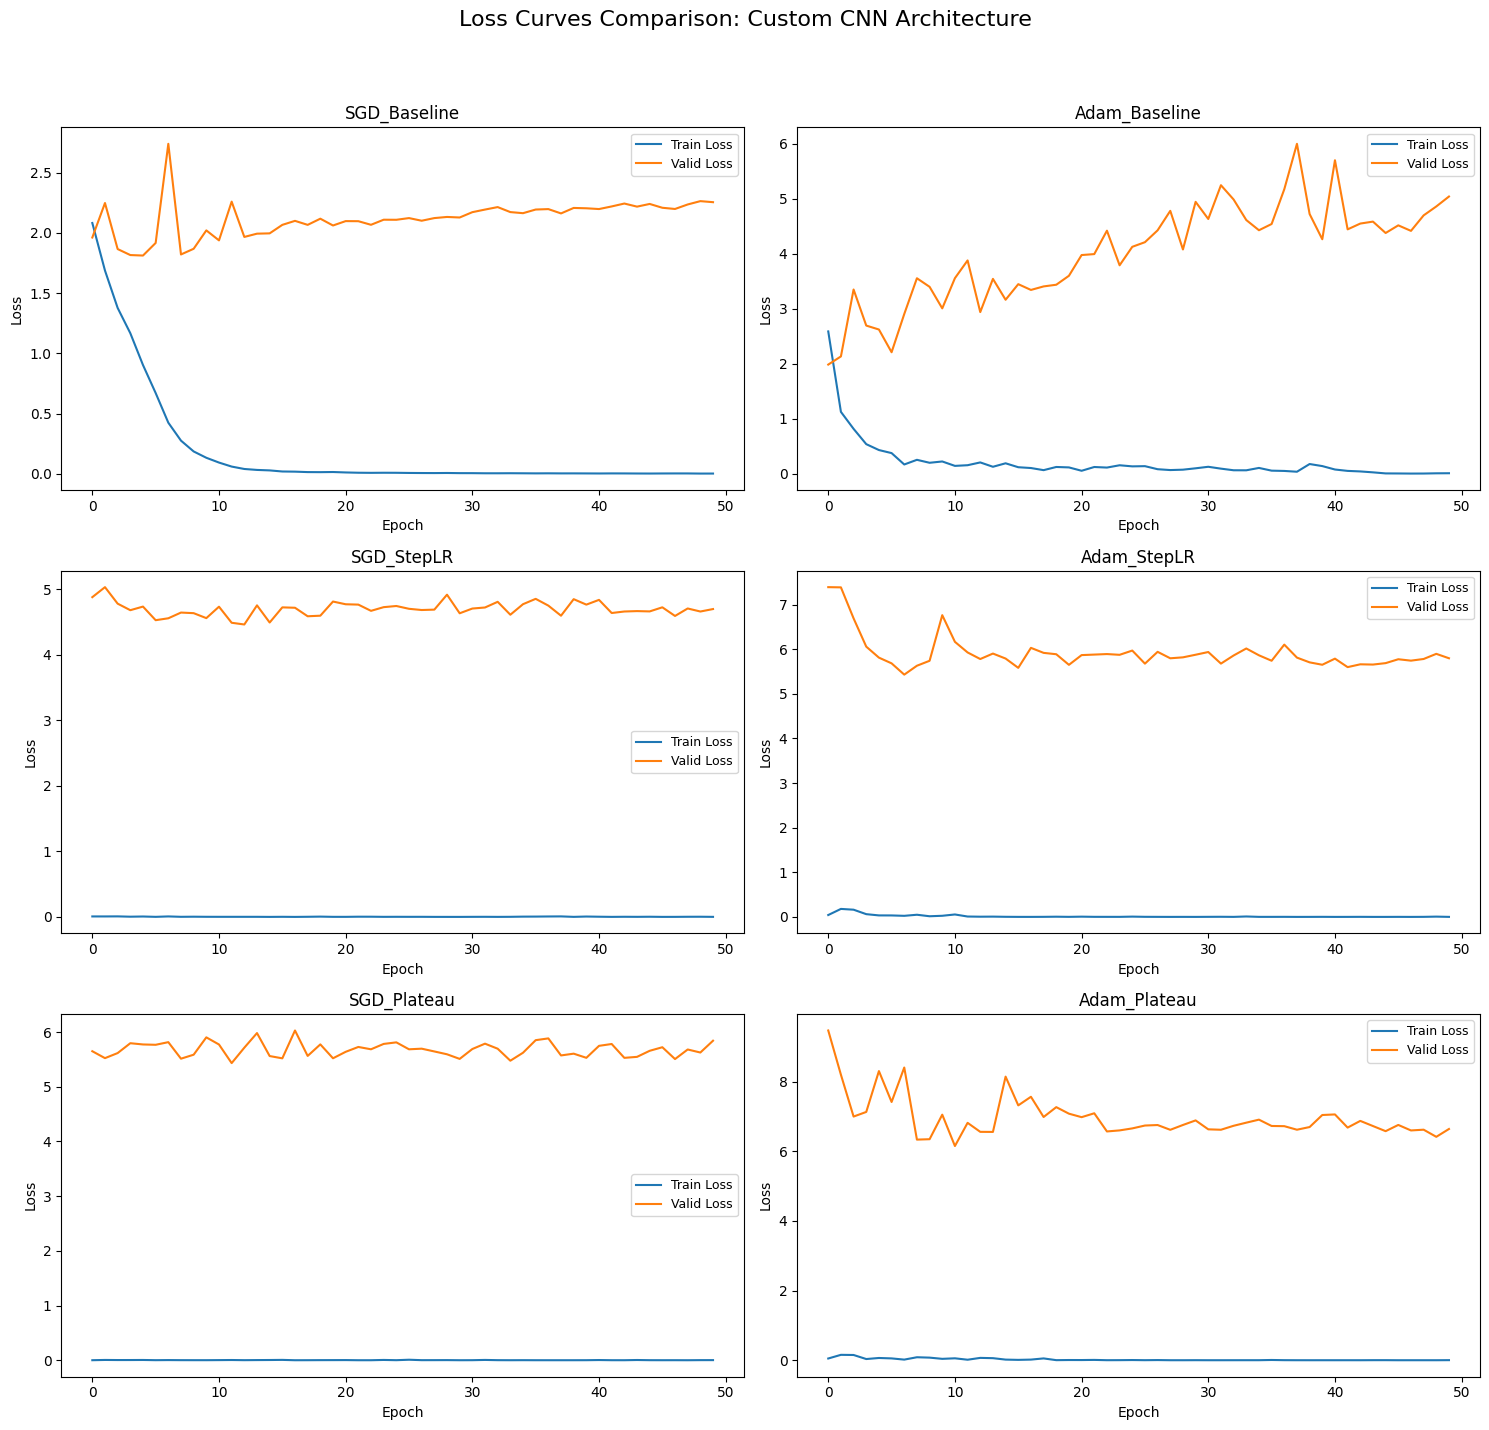

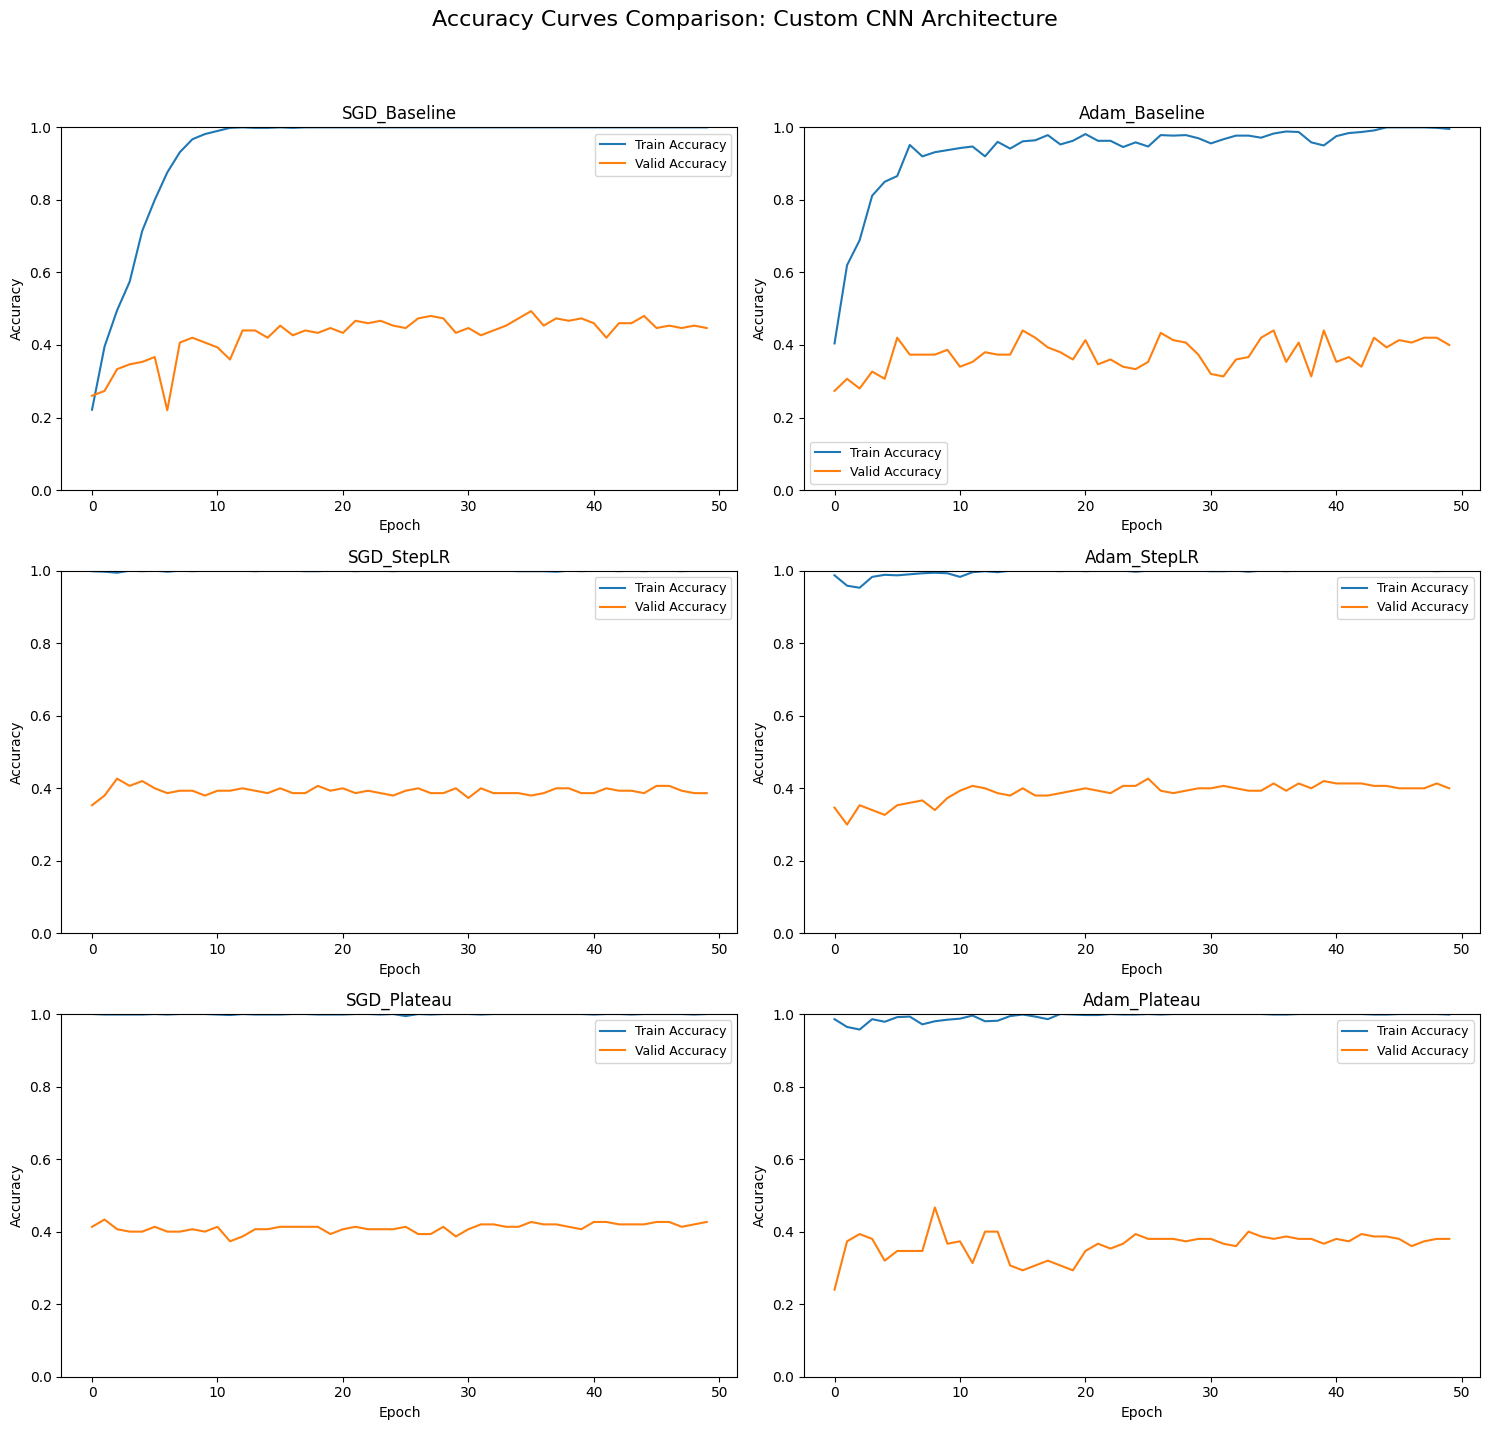

In [53]:
plot_experiment_curves(results_custom, "Custom CNN", "Loss")
plot_experiment_curves(results_custom, "Custom CNN", "Accuracy")

# Loss and Accuracy results:    
* SGD optimizer (baseline): The training loss is smooth and is converging very fast, but valisation loss is not dropping. The train accuracy achoeved 100% very fast, but validation loss is very low, which indicates that the model is overfitted.
* Adam optimizer (baseline): The training loss is dropping, but validation loss is increasing. Here we have similar situation - the model is overfitted.T
* Both schedulers didn't improve the SGD and Adam baseline. It is probably due to the fact that both models are overfitted to the training data and can't generalize on new data.

### Activation maps

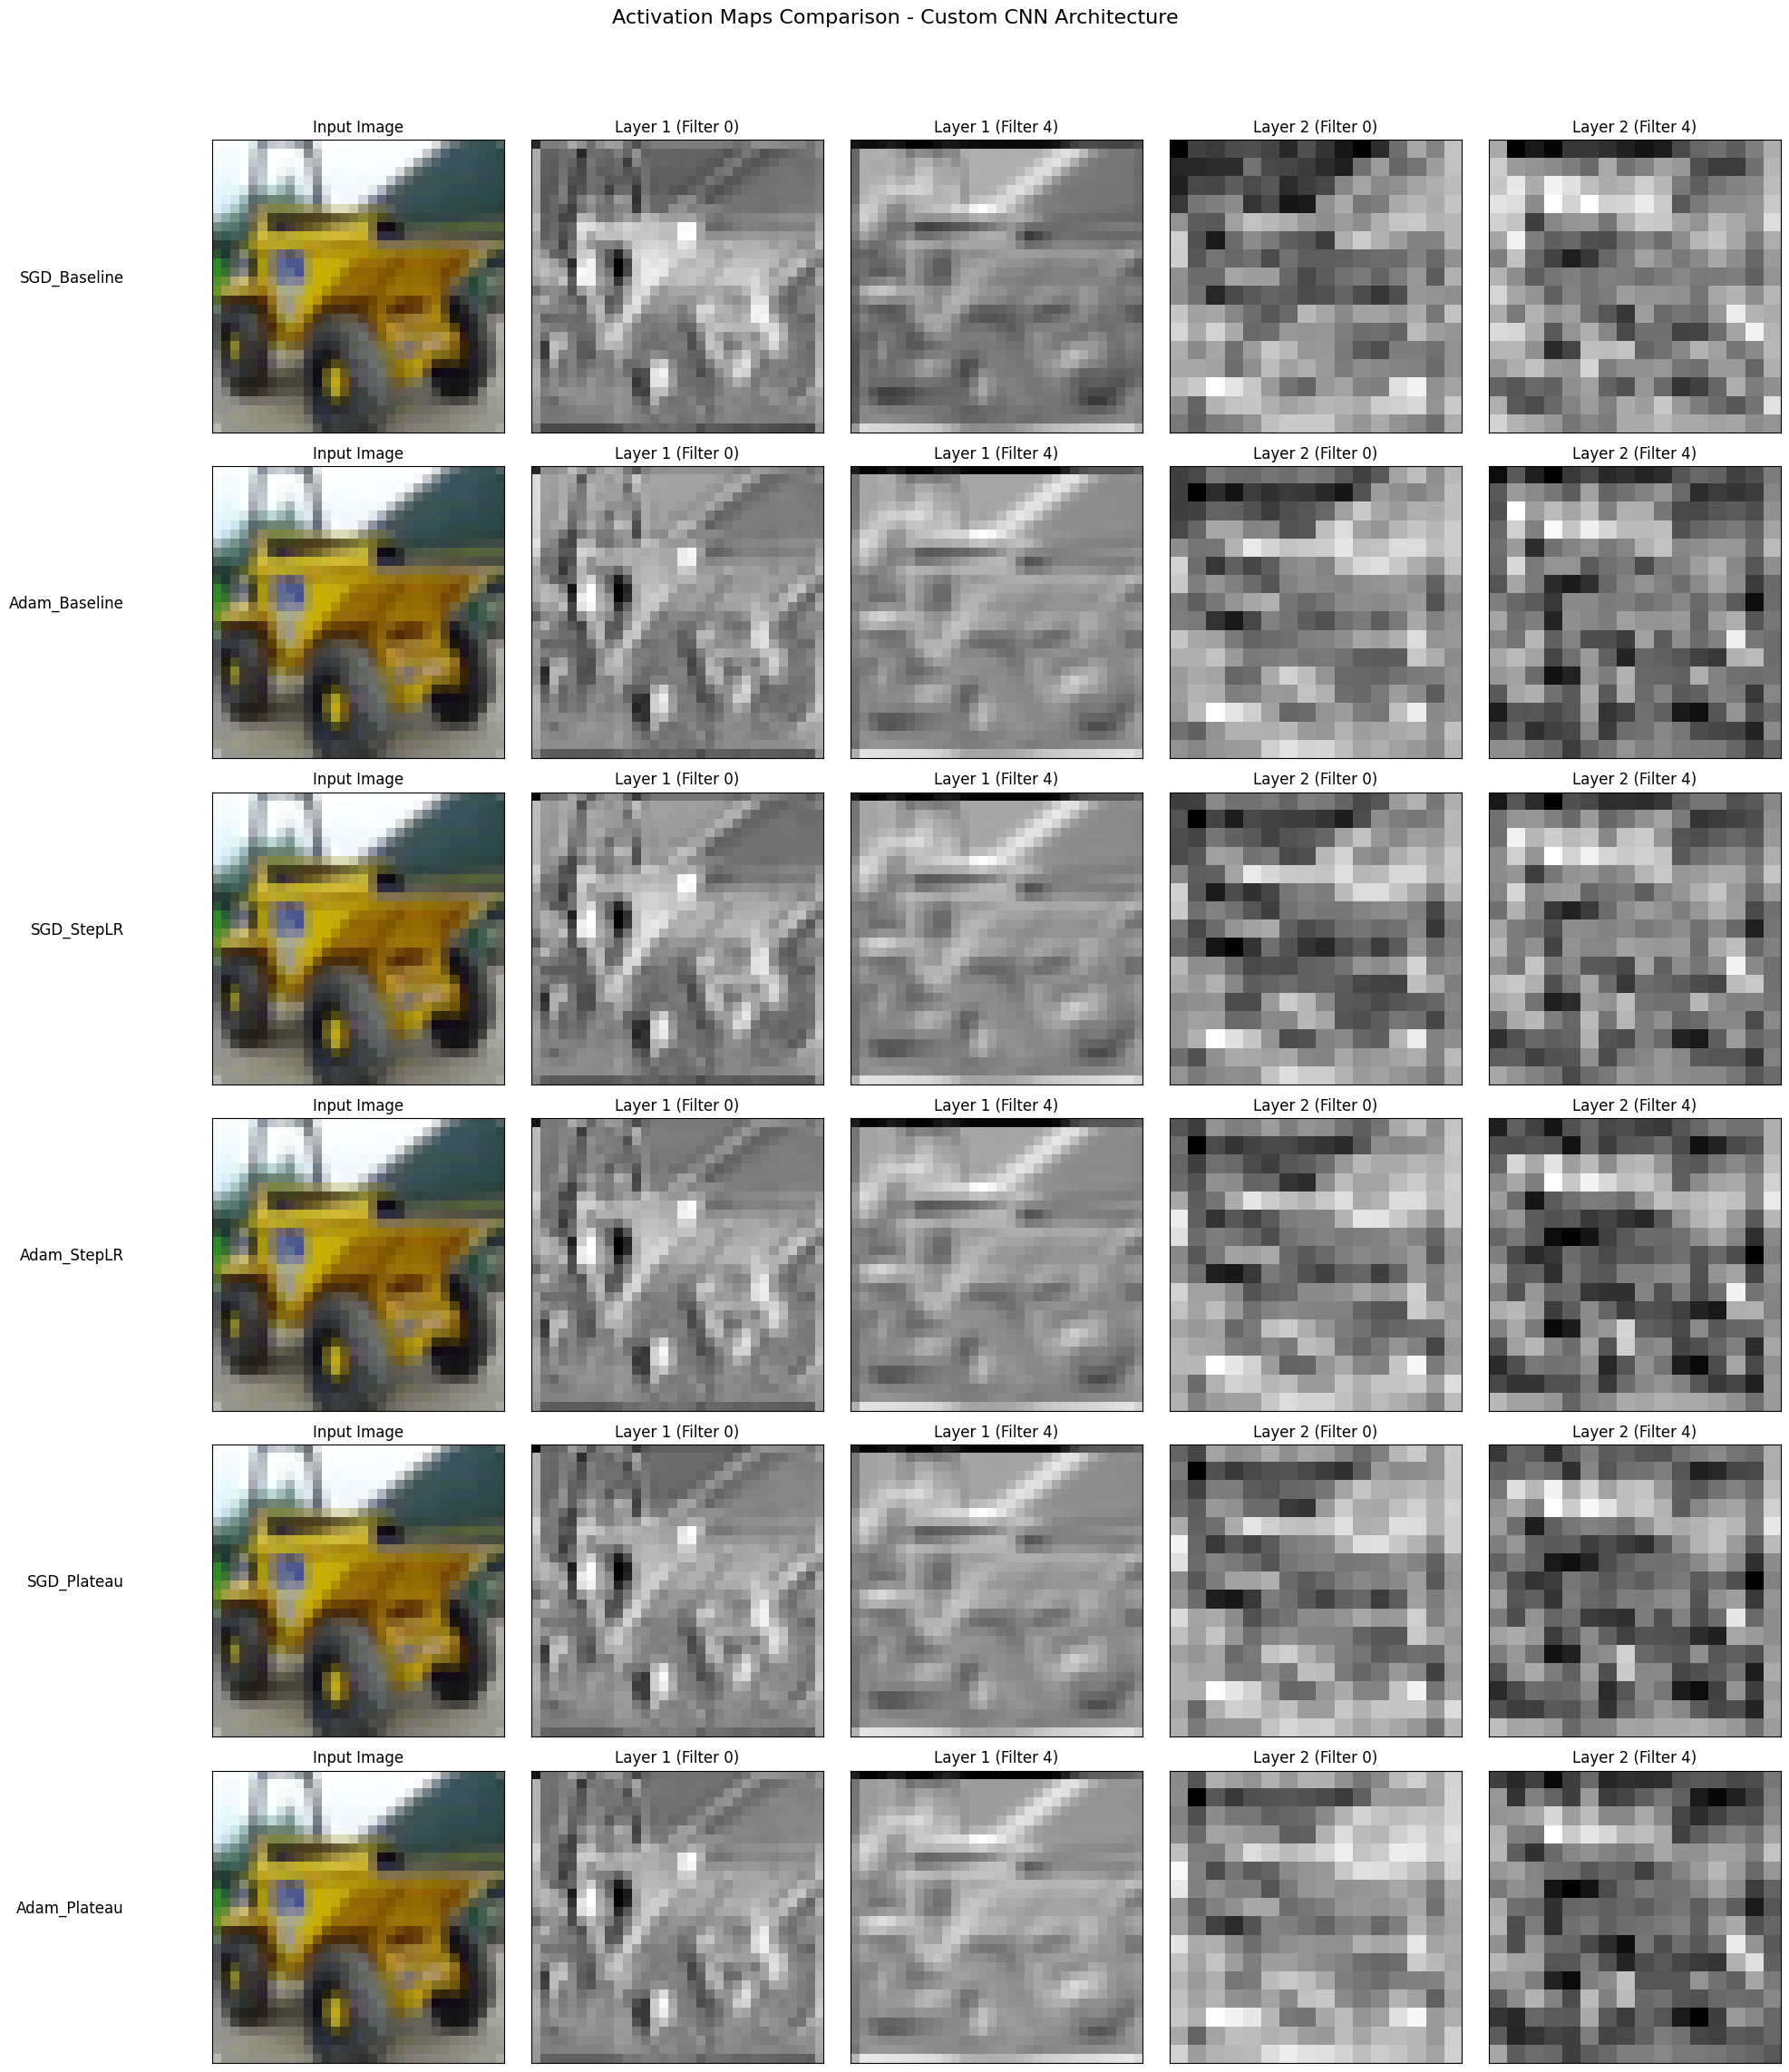

In [54]:
plot_activation_maps(results_custom, "Custom CNN", test_loader)

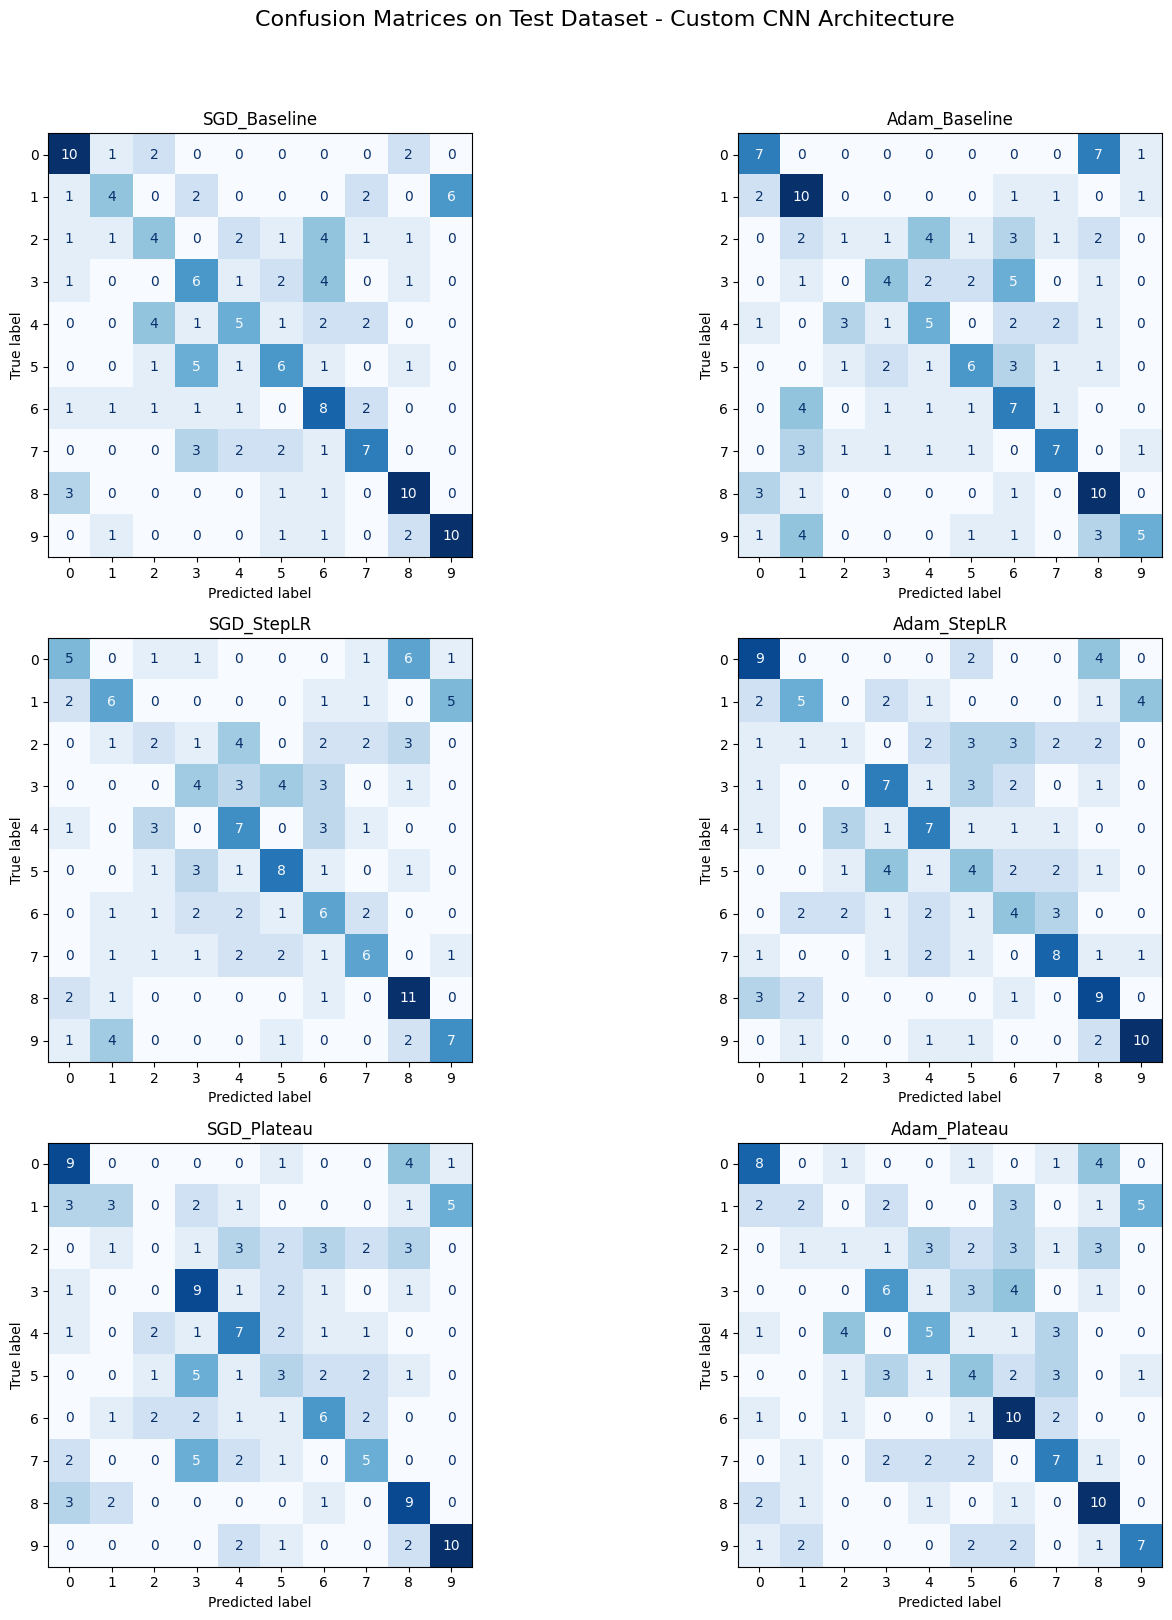

In [55]:
plot_confusion_matrices(results_custom, "Custom CNN")

Goal: Dark diagonal with no off-diagonal spots.

* Calculated confusion matrices indicates that SGD optimizer baseline can better classify data among the classes than Adam optimizer baseline. However both models still do many prediction mistakes.
* Plateau scheduler slightly improved SGD baseline model's predictions.
* StemLR scheduler slightly improved Adam baseline model's predictions.

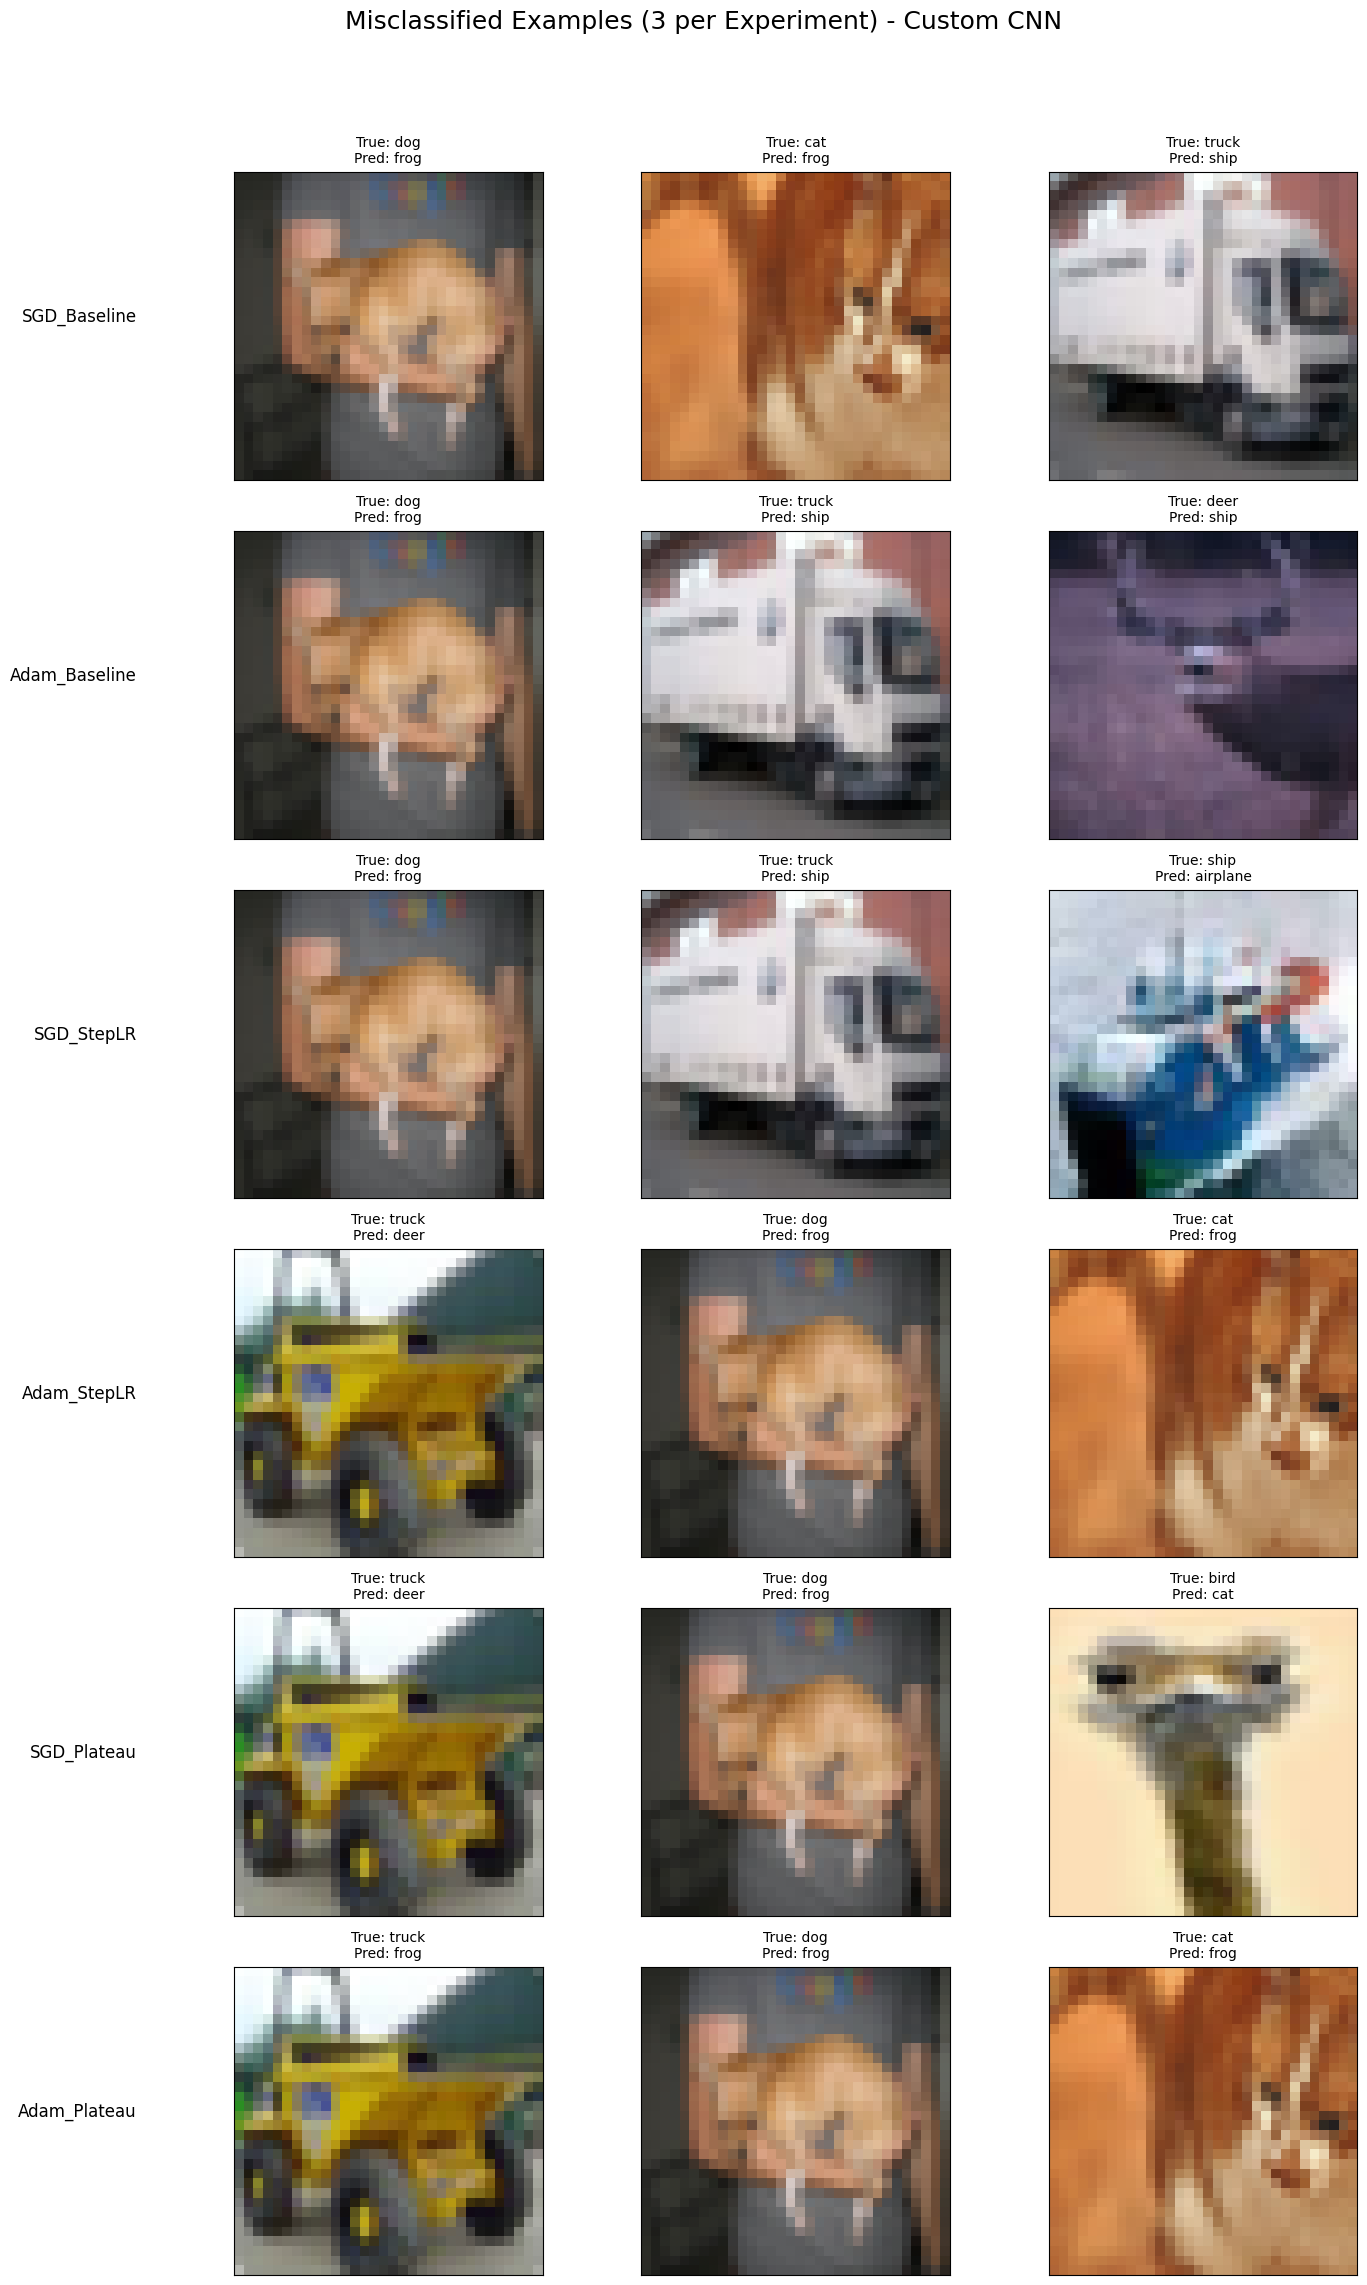

In [56]:
plot_misclassified_images(results_custom, "Custom CNN")

# ResNet

Using pretrained model.

In [57]:
resnet_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2) 
for param in resnet_model.parameters():
    param.requires_grad = False

num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 10) 

for param in resnet_model.fc.parameters():
    param.requires_grad = True
resnet_initial_state = resnet_model.state_dict()

In [58]:
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Experiment parameters

In [59]:
loss_fn = nn.CrossEntropyLoss()
lr_sgd = 0.01
lr_adam = 0.001
epochs = 30

In [60]:
experiments = {
    "SGD_Baseline": {'optim': torch.optim.SGD, 'lr': lr_sgd, 'scheduler': None},
    "Adam_Baseline": {'optim': torch.optim.Adam, 'lr': lr_adam, 'scheduler': None},
    
    "SGD_StepLR": {'optim': torch.optim.SGD, 'lr': lr_sgd,  
                   'scheduler': lambda opt: lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)},
    "Adam_StepLR": {'optim': torch.optim.Adam, 'lr': lr_adam,  
                    'scheduler': lambda opt: lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)},
    "SGD_Plateau": {'optim': torch.optim.SGD, 'lr': lr_sgd, 
                    'scheduler': lambda opt: lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)},
    "Adam_Plateau": {'optim': torch.optim.Adam, 'lr': lr_adam, 
                     'scheduler': lambda opt: lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)},              
    
}

### Training

In [61]:
results_resnet = training_eval_loop(
    model=resnet_model,
    initial_weights=resnet_initial_state,
    model_name="ResNet", 
    experiments=experiments,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,    
    epochs=epochs,
    loss_fn=loss_fn,
    device=device
)


===== Experiment: SGD_Baseline =====
E1: Train Loss=2.1506 Accuracy=0.3386 | Val Loss=2.0107 Accuracy=0.5600 | lr=0.010000
E2: Train Loss=1.8665 Accuracy=0.5329 | Val Loss=1.7988 Accuracy=0.6533 | lr=0.010000
E3: Train Loss=1.6825 Accuracy=0.5829 | Val Loss=1.6328 Accuracy=0.6733 | lr=0.010000
E4: Train Loss=1.5553 Accuracy=0.6514 | Val Loss=1.5199 Accuracy=0.6800 | lr=0.010000
E5: Train Loss=1.4323 Accuracy=0.6329 | Val Loss=1.4347 Accuracy=0.6533 | lr=0.010000
E6: Train Loss=1.3610 Accuracy=0.6357 | Val Loss=1.3321 Accuracy=0.7200 | lr=0.010000
E7: Train Loss=1.2963 Accuracy=0.6786 | Val Loss=1.3047 Accuracy=0.7333 | lr=0.010000
E8: Train Loss=1.2121 Accuracy=0.7057 | Val Loss=1.2388 Accuracy=0.7067 | lr=0.010000
E9: Train Loss=1.1749 Accuracy=0.7086 | Val Loss=1.1851 Accuracy=0.7000 | lr=0.010000
E10: Train Loss=1.1401 Accuracy=0.6943 | Val Loss=1.1728 Accuracy=0.6867 | lr=0.010000
E11: Train Loss=1.1134 Accuracy=0.7157 | Val Loss=1.0819 Accuracy=0.7267 | lr=0.010000
E12: Train Los

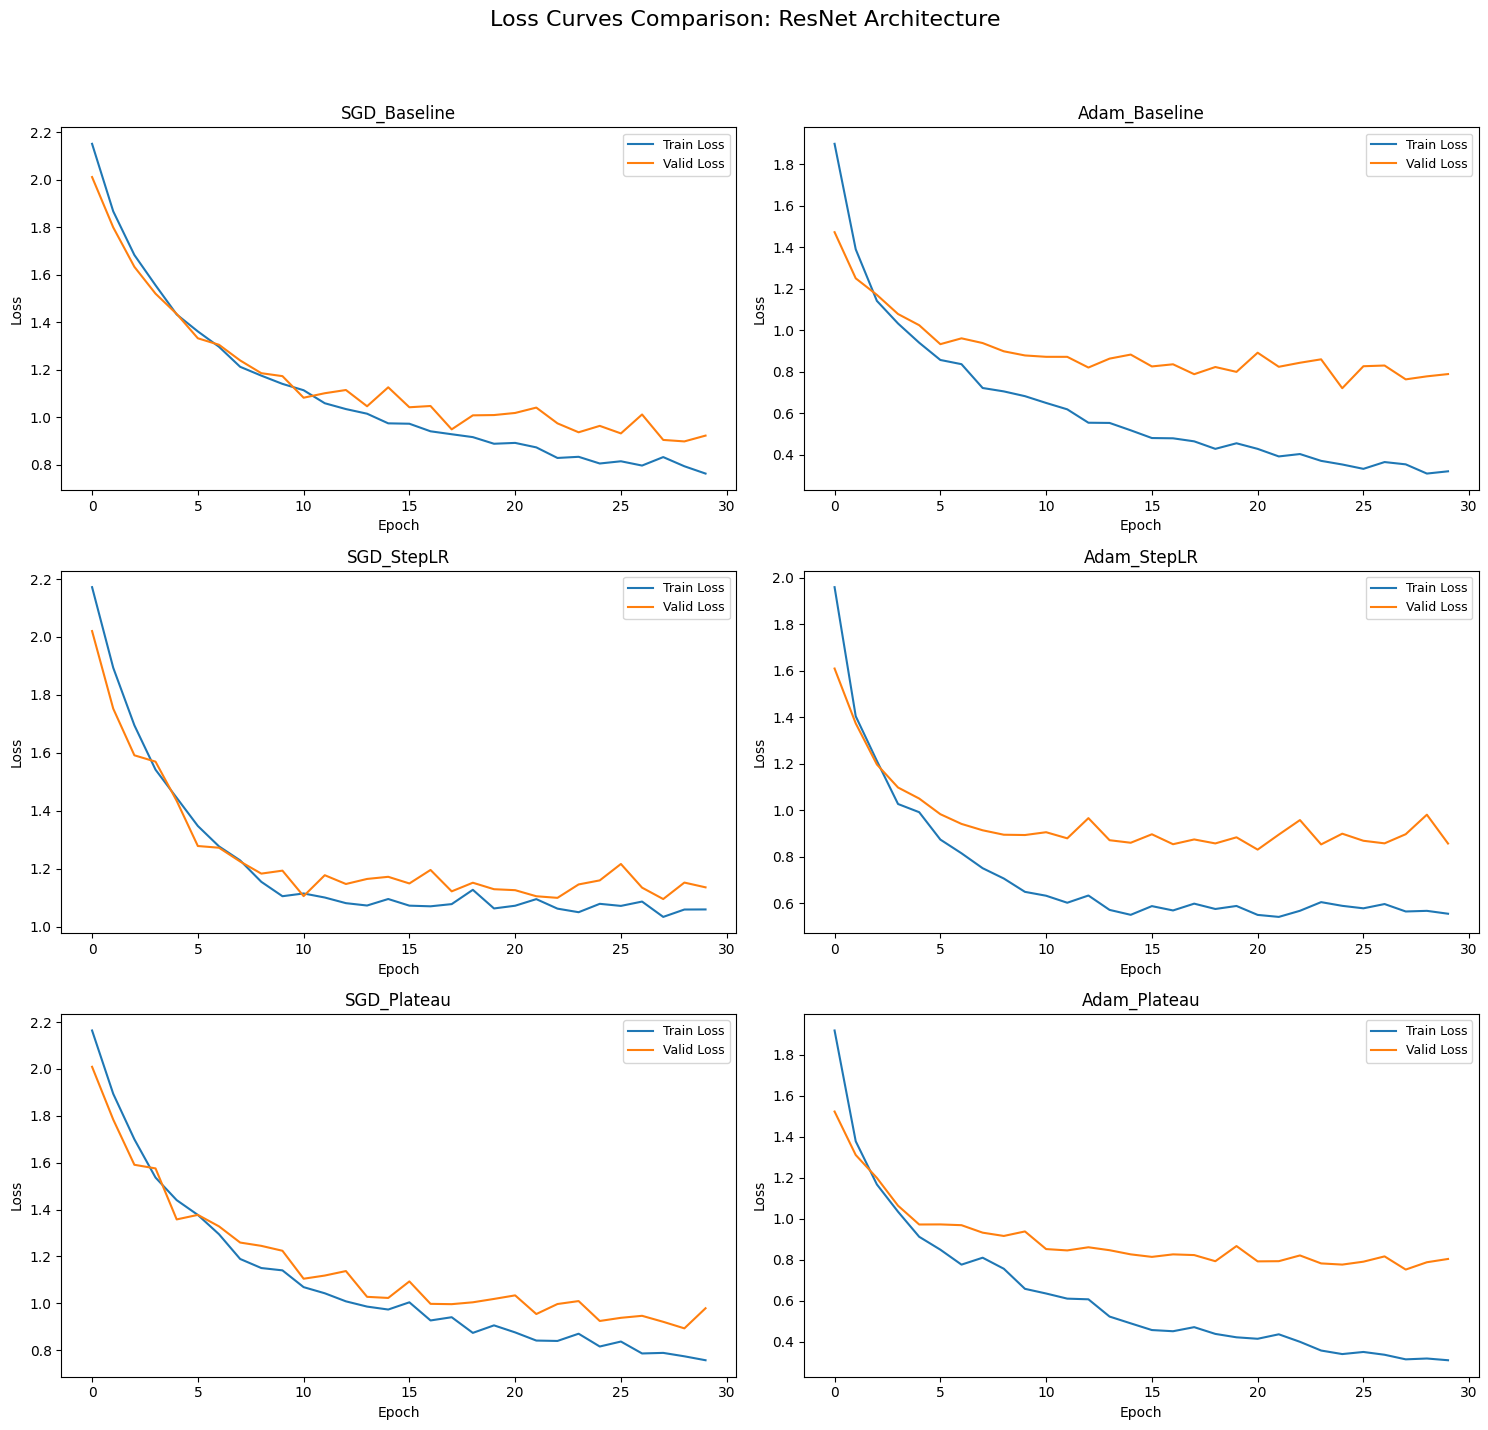

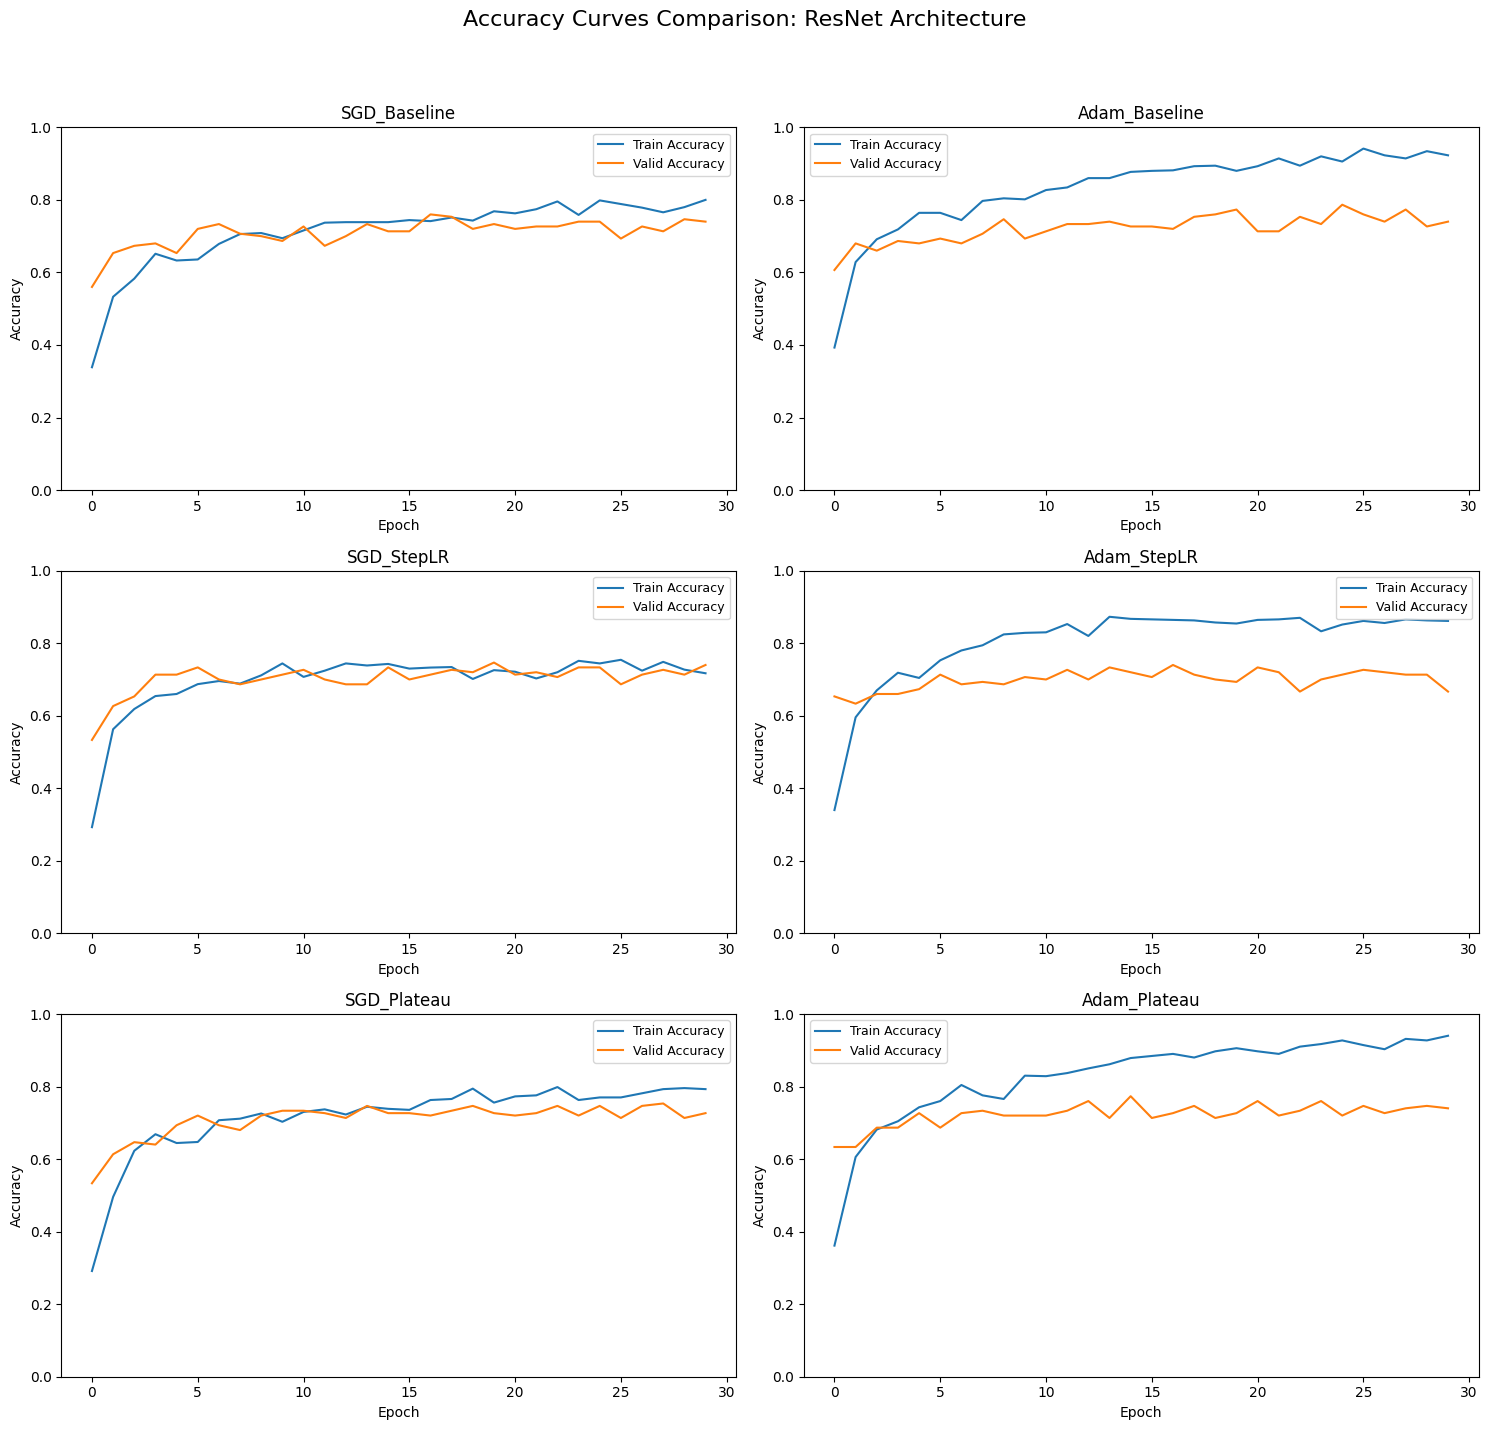

In [62]:
plot_experiment_curves(results_resnet, "ResNet", "Loss")
plot_experiment_curves(results_resnet, "ResNet", "Accuracy")

* All experiments achieved very good results - validation accuracy approximately 75%.
* In SGD optimizer models the validation loss and accuracy is very similar to training loss - there is definitely no overfitting.
* In Adam optimizer model the training loss is decreasing faster. The validation losss has higher values than training loss and validation accuracy has lower scores than traning accuracy.
* Both schedulers didn't change much both SGD and Adam baseline models performance - likely because model was learning steadily without any main issues.

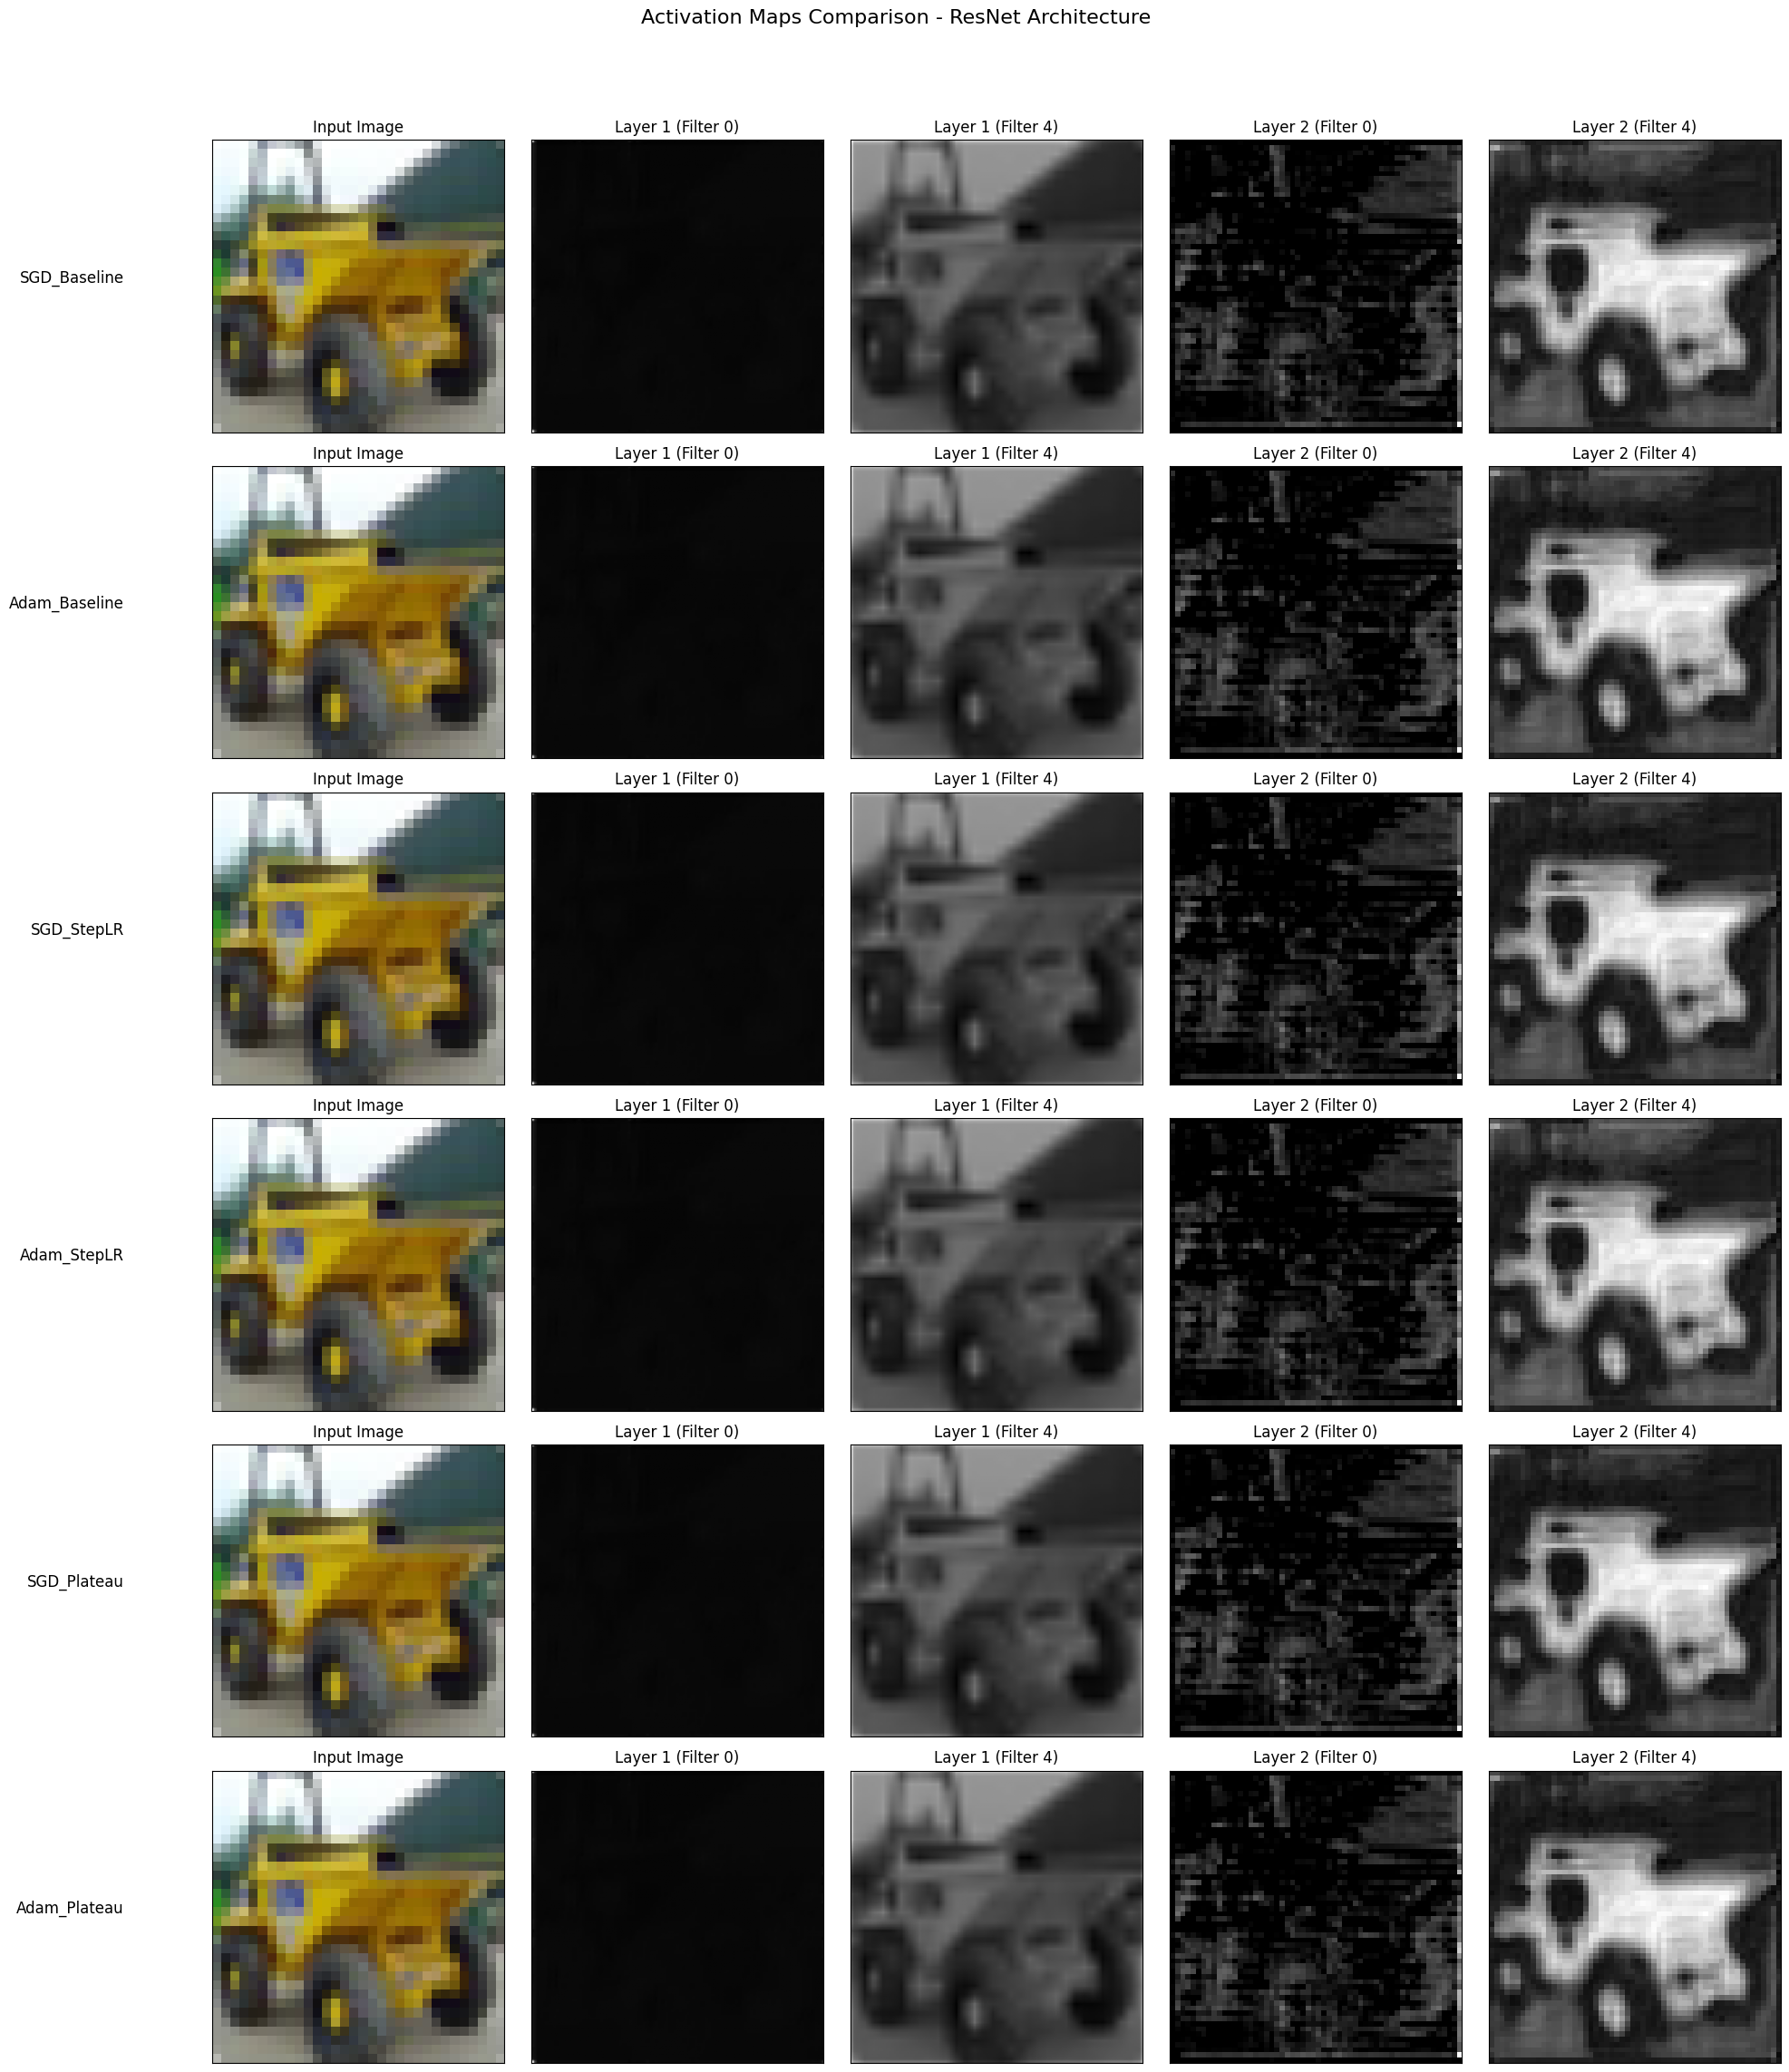

In [63]:
plot_activation_maps(results_resnet, "ResNet", test_loader)

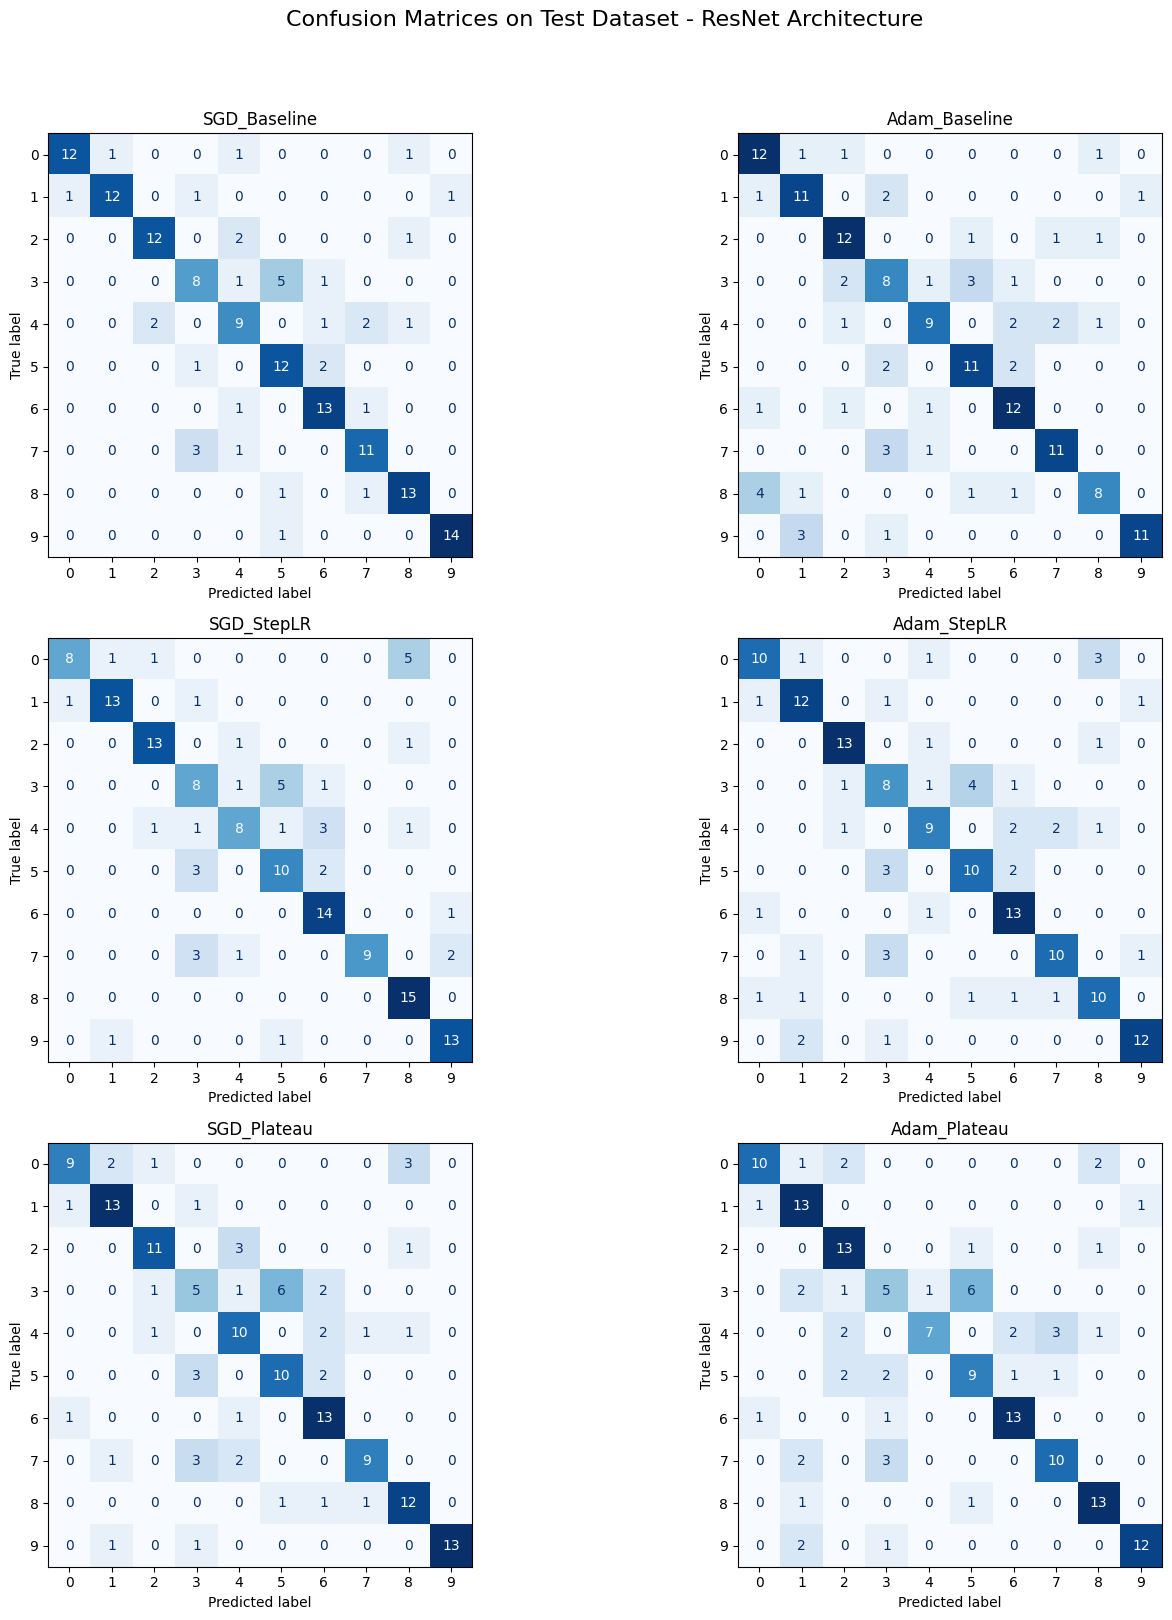

In [64]:
plot_confusion_matrices(results_resnet, "ResNet")

All confusion matrices has very strong and dark diagonal, which indoicates that models predictions on test dataset are very good. It's hard to define which model variantion achieved better scores.

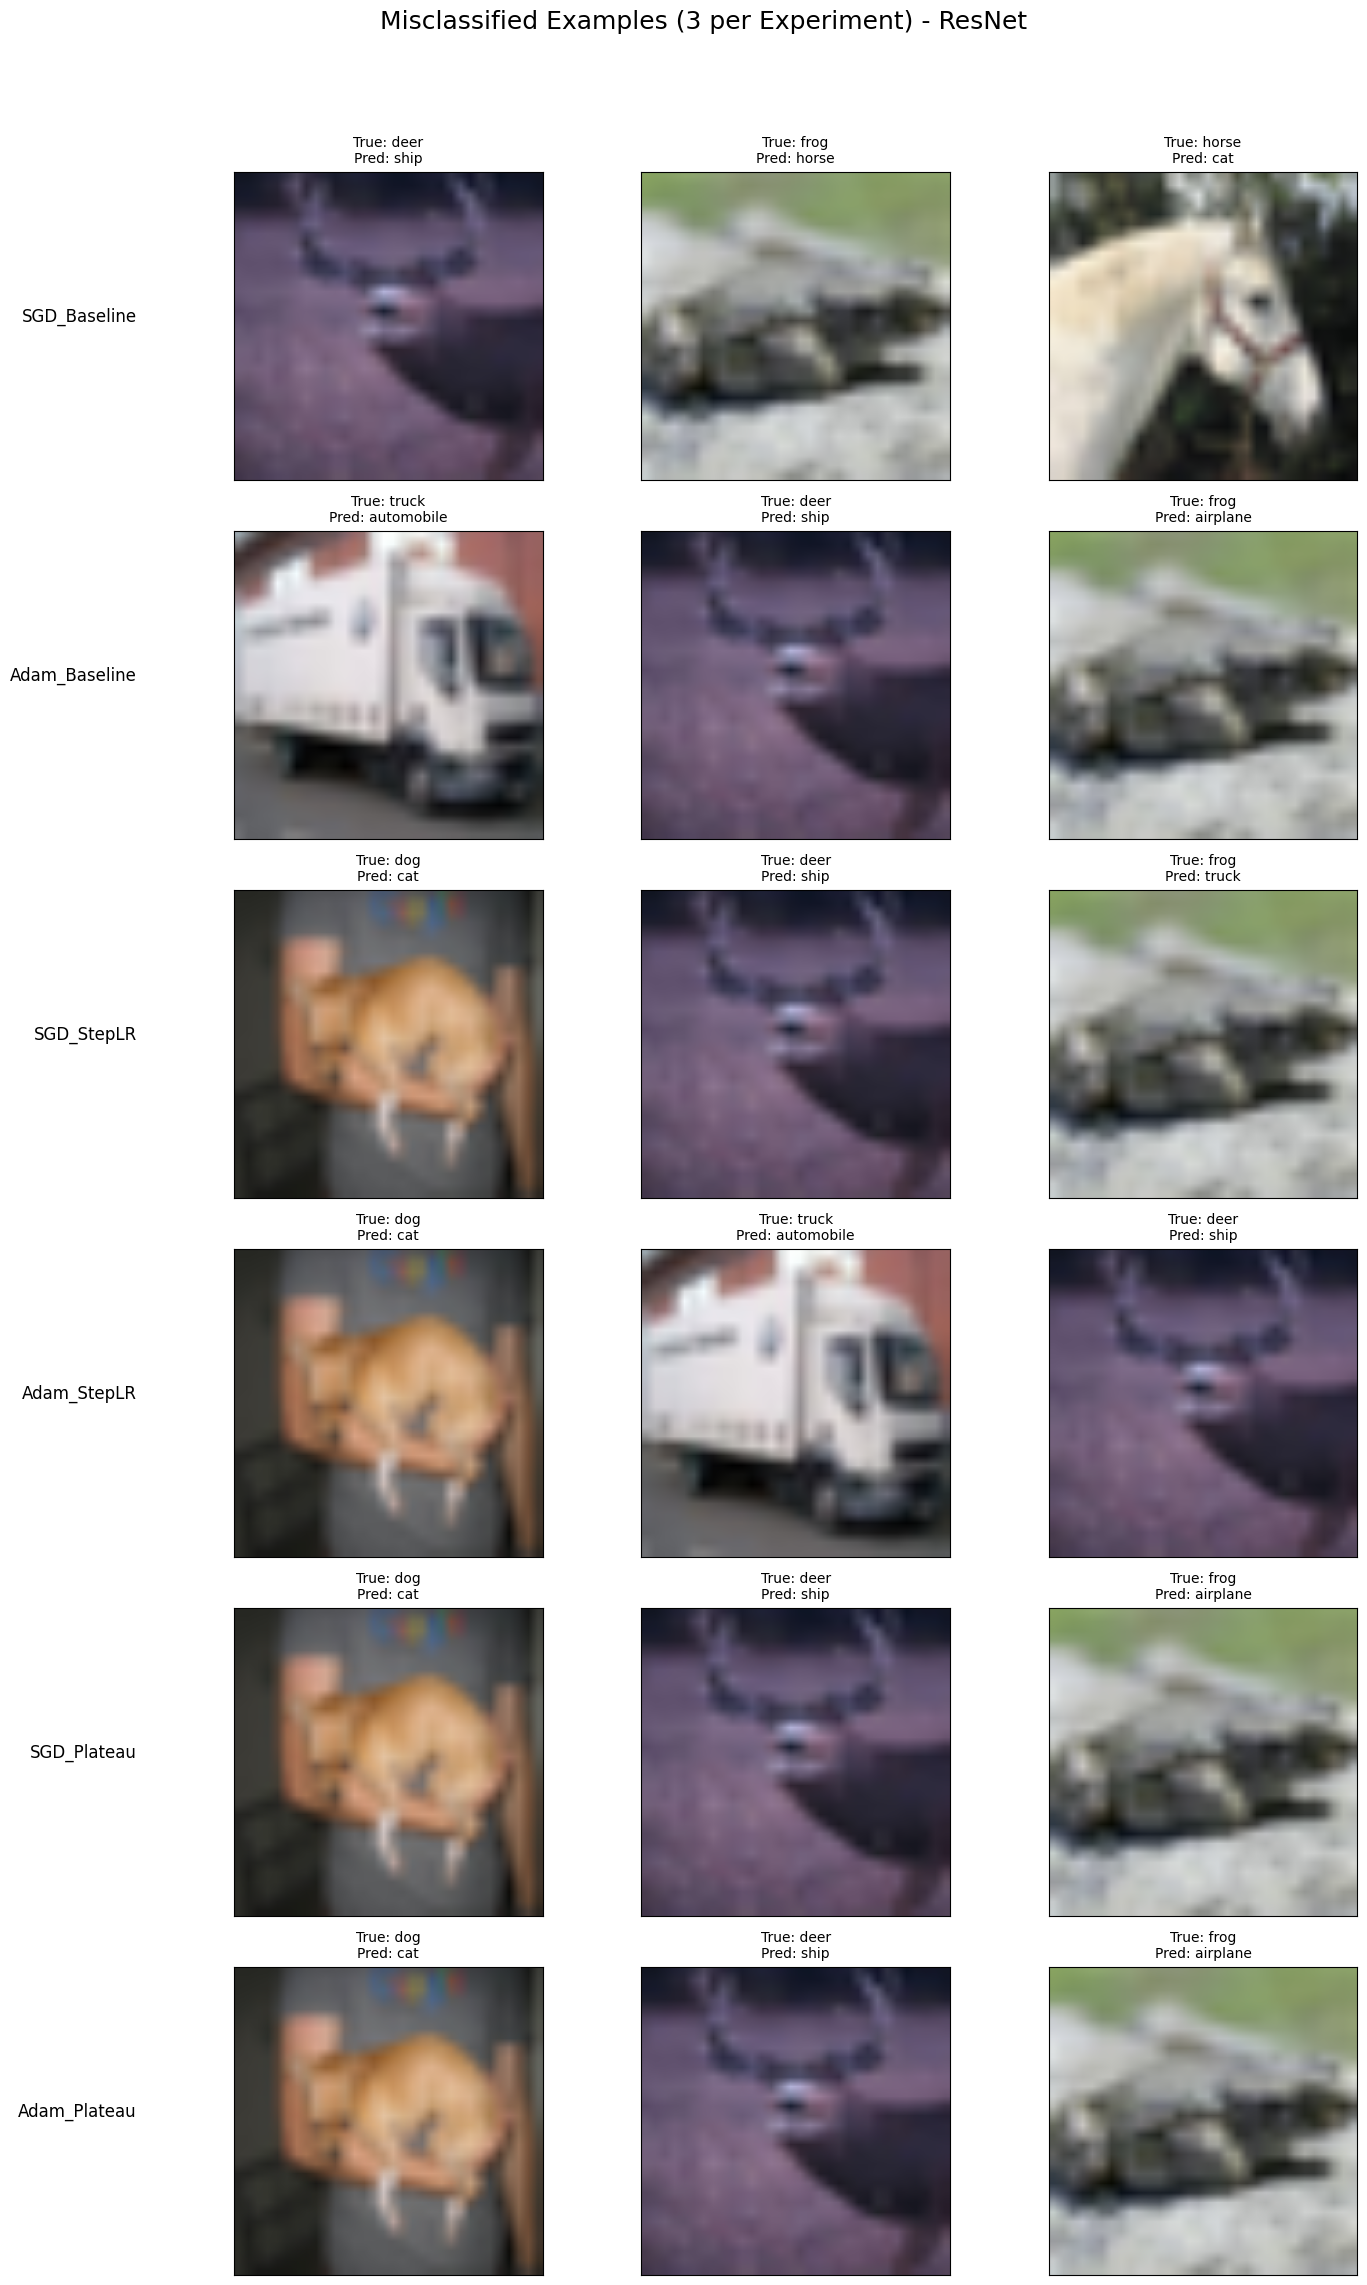

In [65]:
plot_misclassified_images(results_resnet, "ResNet")

# Accuracy comparison

In [69]:
def create_summary_dataframe(results_dict, model_name):

    results_list = []
    
    for experiment_name, data in results_dict.items():
        # 1. Find the best validation accuracy and the epoch it occurred
        valid_acc_list = data['valid_acc']
        best_val_acc = max(valid_acc_list)
        
        # +1 because lists are 0-indexed, but epochs are 1-indexed
        # --- POPRAWIONA LITERÓWKA PONIŻEJ ---
        best_epoch = np.argmax(valid_acc_list) + 1 
        
        # 2. Calculate the overall test accuracy from the confusion matrix
        cm = data['confusion_matrix']
        correct_predictions = np.trace(cm) # Sum of the diagonal
        total_predictions = np.sum(cm)   # Sum of all elements
        
        # Avoid division by zero if the matrix is empty
        if total_predictions > 0:
            test_accuracy = correct_predictions / total_predictions
        else:
            test_accuracy = 0.0
        
        # Add results to our list
        results_list.append({
            "Model": model_name,
            "Experiment": experiment_name,
            "Best Validation Accuracy": best_val_acc,
            "Best Epoch": best_epoch,
            "Overall Test Accuracy": test_accuracy
        })
        
    return pd.DataFrame(results_list)

# --- Main Execution ---

# 1. Process both results dictionaries
df_custom_cnn = create_summary_dataframe(results_custom, "Custom CNN")
df_resnet = create_summary_dataframe(results_resnet, "ResNet")

# 2. Combine them into one single table
all_results_df = pd.concat([df_custom_cnn, df_resnet])

# 3. Set a multi-index for cleaner display
all_results_df = all_results_df.set_index(['Model', 'Experiment'])

# 4. Format the accuracy columns to be more readable (as percentages)
all_results_df['Best Validation Accuracy'] = all_results_df['Best Validation Accuracy'].map('{:.2%}'.format)

# --- POPRAWIONA LITERÓWKA PONIŻEJ ---
all_results_df['Overall Test Accuracy'] = all_results_df['Overall Test Accuracy'].map('{:.2%}'.format)

# 5. Print the final table
print("--- Model Performance Summary ---")
display(all_results_df)

--- Model Performance Summary ---


Best Validation Accuracy  Best Epoch  \
Model      Experiment                                           
Custom CNN SGD_Baseline                    49.33%          36   
           Adam_Baseline                   44.00%          16   
           SGD_StepLR                      42.67%           3   
           Adam_StepLR                     42.67%          26   
           SGD_Plateau                     43.33%           2   
           Adam_Plateau                    46.67%           9   
ResNet     SGD_Baseline                    76.00%          17   
           Adam_Baseline                   78.67%          25   
           SGD_StepLR                      74.67%          20   
           Adam_StepLR                     74.00%          17   
           SGD_Plateau                     75.33%          28   
           Adam_Plateau                    77.33%          15   

                         Overall Test Accuracy  
Model      Experiment                           
Custom CNN SGD_Baseline                 46.67%  
           Adam_Baseline                41.33%  
           SGD_StepLR                   41.33%  
           Adam_StepLR                  42.67%  
           SGD_Plateau                  40.67%  
           Adam_Plateau                 40.00%  
ResNet     SGD_Baseline                 77.33%  
           Adam_Baseline                70.00%  
           SGD_StepLR                   74.00%  
           Adam_StepLR                  71.33%  
           SGD_Plateau                  70.00%  
           Adam_Plateau                 70.00%

In both architectures, the best test accuracy achieved SGD optimizer baseline without using any schedulers.

# Final conclusions


1. Architecture: Custom CNN vs. ResNet (Transfer Learning)

    * Custom CNN: This architecture suffered from extreme overfitting. While train accuracy quickly reached 100%, validation accuracy remained very low (around 40-50%). This indicates that the model architecture wasn't appropriate for given dataset (it was probbaly too complex or lacked some regularization techniques, as the model memorized traning dataset, but was not able to generalize on validation dataset).

    * ResNet: This model demonstrated excellent performance and solved the overfitting problem. By using transfer learning, the model started with  pre-trained weights. This resulted in high validation accuracy (approx. 70-80%) where the validation and training curves were almost identical. This proves the ResNet architecture was far more suitable and robust for this task.

2. Schedulers: StepLR and ReduceLROnPlateau

    * Why they failed on the Custom CNN: The Custom CNN was overfitted and adjusting the learning rate cannot fix a fundamental generalization issue.

    * Why they had minimal effect on the ResNet: The ResNet models were learning almost perfectly. The Baseline models were already so stable that the validation loss was constantly decreasing.

    * ReduceLROnPlateau is reactive and it activates when the validation loss stops improving. 

    * StepLR decays the learning rate by a fixed factor every specified number of epochs. So it probably did have a visible effect on ResNet model, but it didn't significantly beat the baseline ResNet model, because the baseline was already performing very good.

    * Schedulers are most useful when model has stagnation. 
